# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

save = False

# Spectral feature

## Question 6

In [3]:
def gamma_hat(signal):
    signal = signal - signal.mean()
    N = len(signal)
    corr = np.correlate(signal, signal, mode="full")[N-1:] / N
    return corr

def J(signal):
    N = len(signal)
    signal = signal - signal.mean()
    S = np.fft.fft(signal)
    
    return (np.abs(1/np.sqrt(N) * S)**2)[:N//2 + 1]


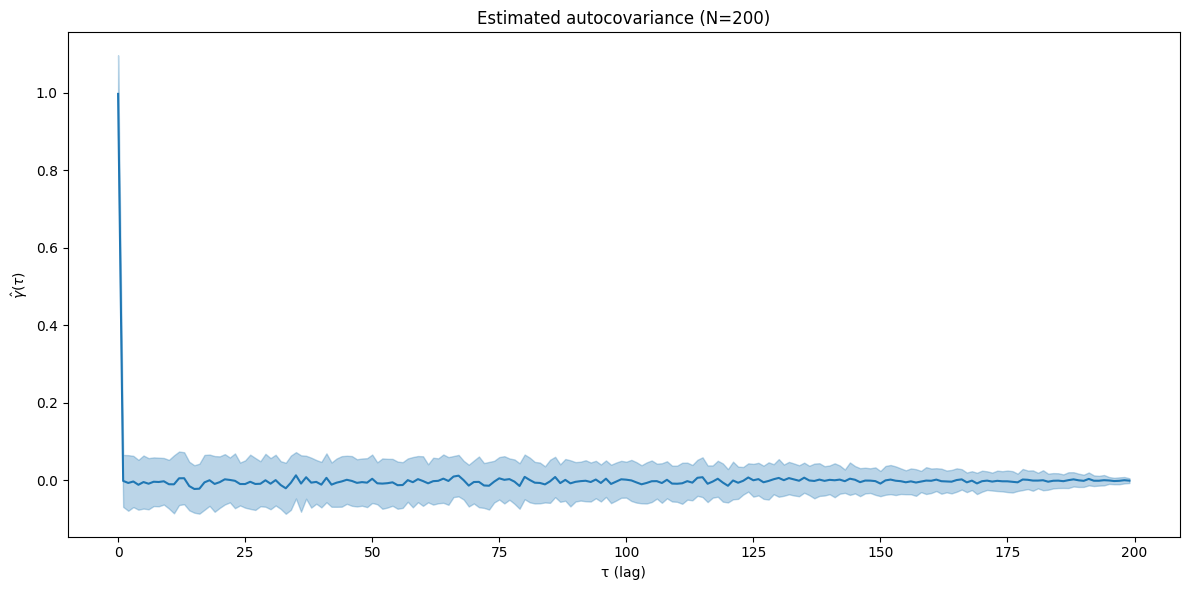

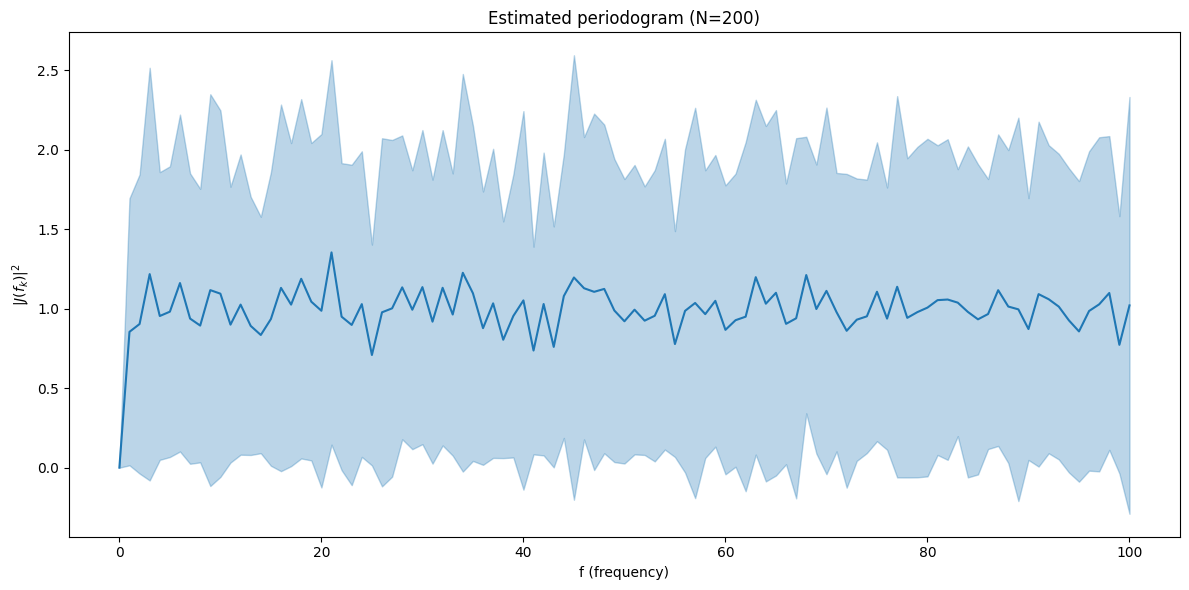

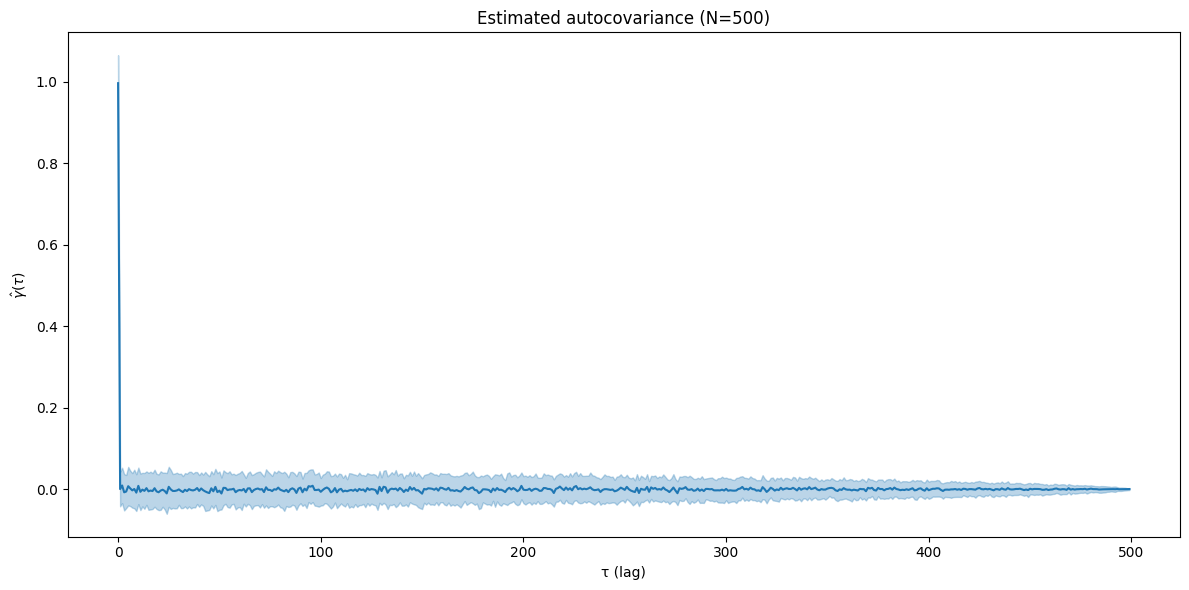

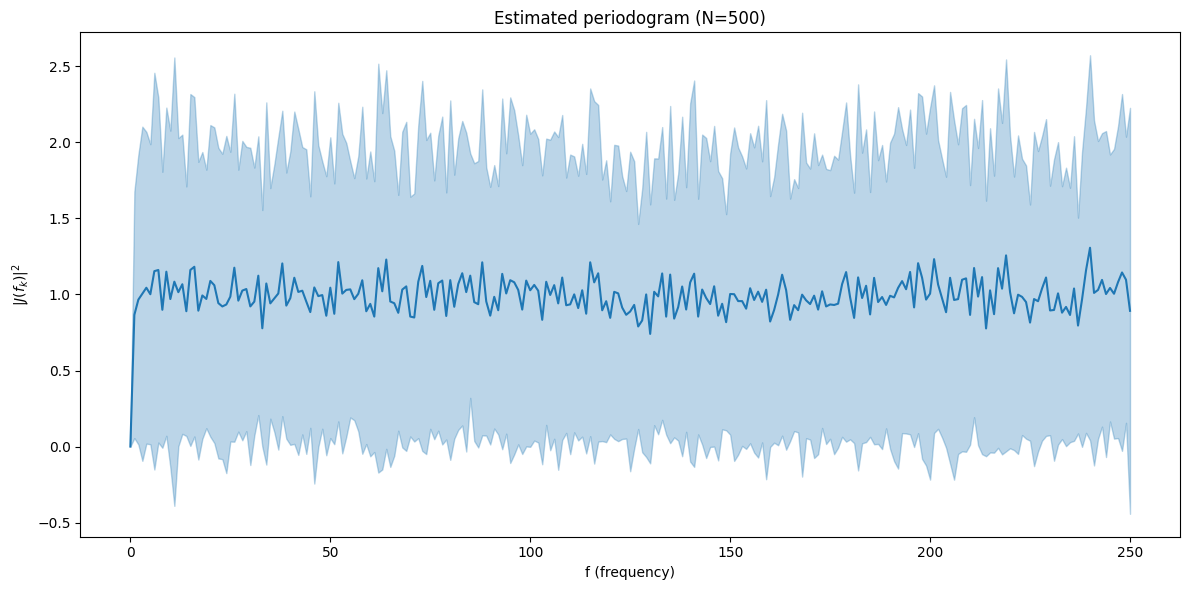

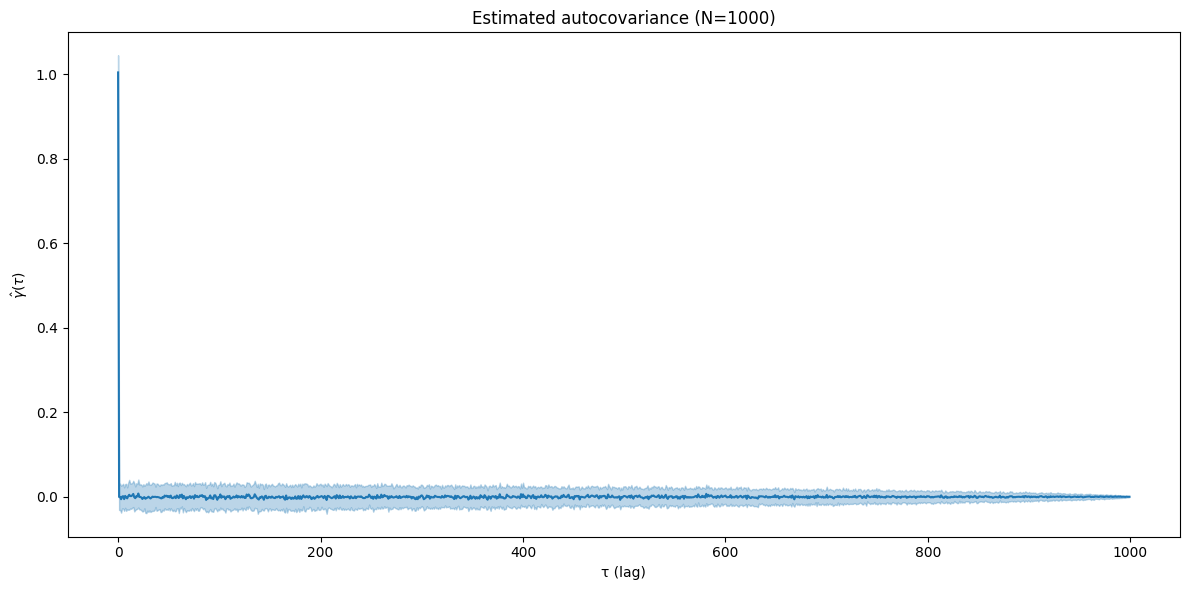

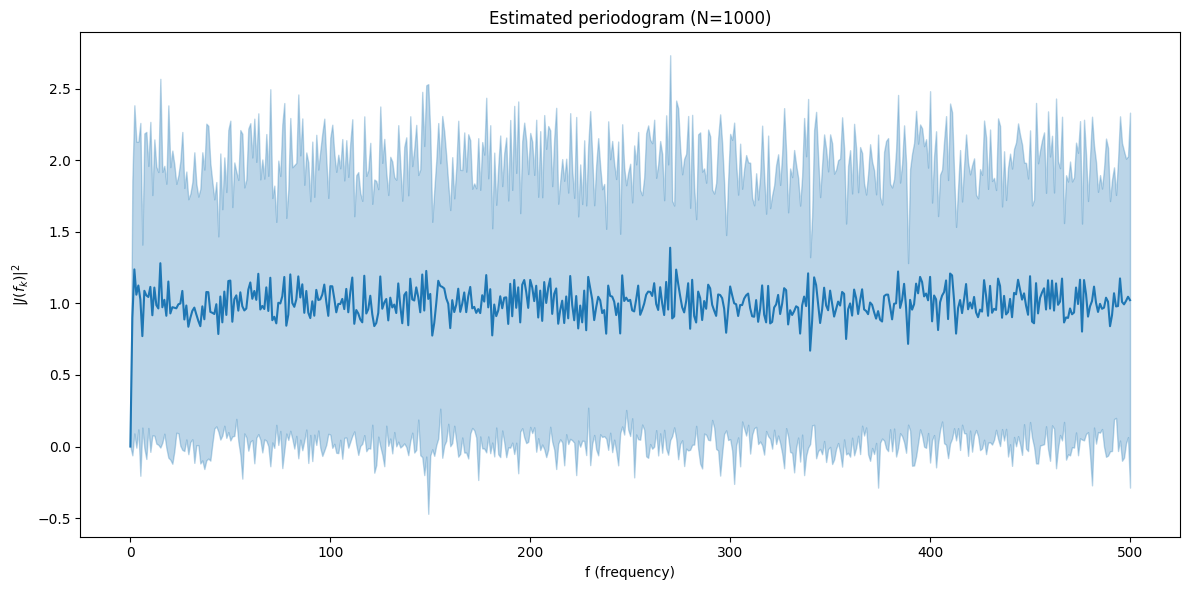

In [4]:
### Sample autocovariances ###

Ns = [200,500,1000]
N_sim = 100

for N in Ns:
    signals = np.random.randn(N_sim, N)
    gamma = np.zeros((N_sim,N))
    Jf = np.zeros((N_sim, N//2+1))
    for i,signal in enumerate(signals):
        gamma[i] = gamma_hat(signal)
        Jf[i] = J(signal)


    mean = gamma.mean(axis=0)
    std = gamma.std(axis=0)
    taus = np.arange(N)

    mean_freq_powe = Jf.mean(axis=0)
    std_freq_powe = Jf.std(axis=0)
    freqs = np.arange(N//2+1)

    plt.figure(figsize=(12, 6))
    plt.plot(taus, mean, color='C0')
    plt.fill_between(taus, mean - std, mean + std, color='C0', alpha=0.3)
    plt.xlabel("τ (lag)")
    plt.ylabel(r"$\hat{\gamma}(\tau)$")
    plt.title(f"Estimated autocovariance (N={N})")
    plt.tight_layout()
    if save:
        plt.savefig(f"figures/gamma_N{N}.png", dpi=300)
    plt.show()
    plt.close()  

    plt.figure(figsize=(12, 6))
    plt.plot(freqs, mean_freq_powe, color='C0')
    plt.fill_between(freqs, mean_freq_powe - std_freq_powe, mean_freq_powe + std_freq_powe, color='C0', alpha=0.3)
    plt.xlabel("f (frequency)")
    plt.ylabel(r"$|J(f_k)|^2$")
    plt.title(f"Estimated periodogram (N={N})")
    plt.tight_layout()
    if save:
        plt.savefig(f"figures/Jfk2_N{N}.png", dpi=300)
    plt.show()
    plt.close()  




## Question 9

In [5]:
# Bartlett's procedure
def bartlett_procedure(signal, K):
    N = len(signal)
    L = N // K
    Jf_bartlett = np.zeros((K, L//2 + 1))
    for k in range(K):
        segment = signal[k*L:(k + 1)*L]
        Jf_bartlett[k] = J(segment)
    Jf_bartlett_mean = Jf_bartlett.mean(axis=0)
    return Jf_bartlett_mean

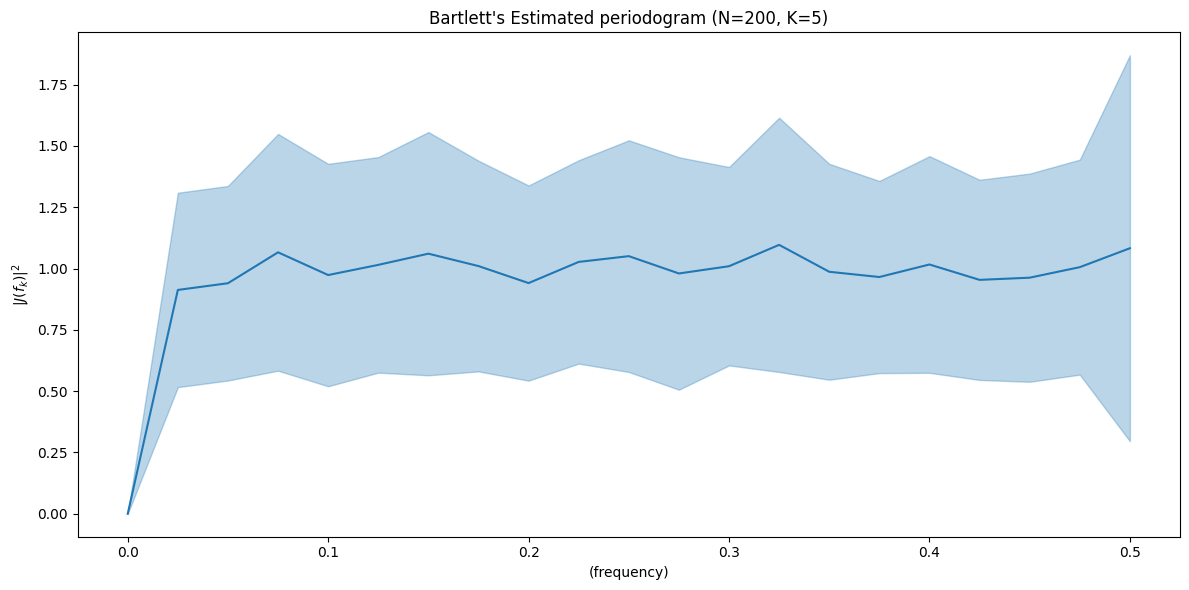

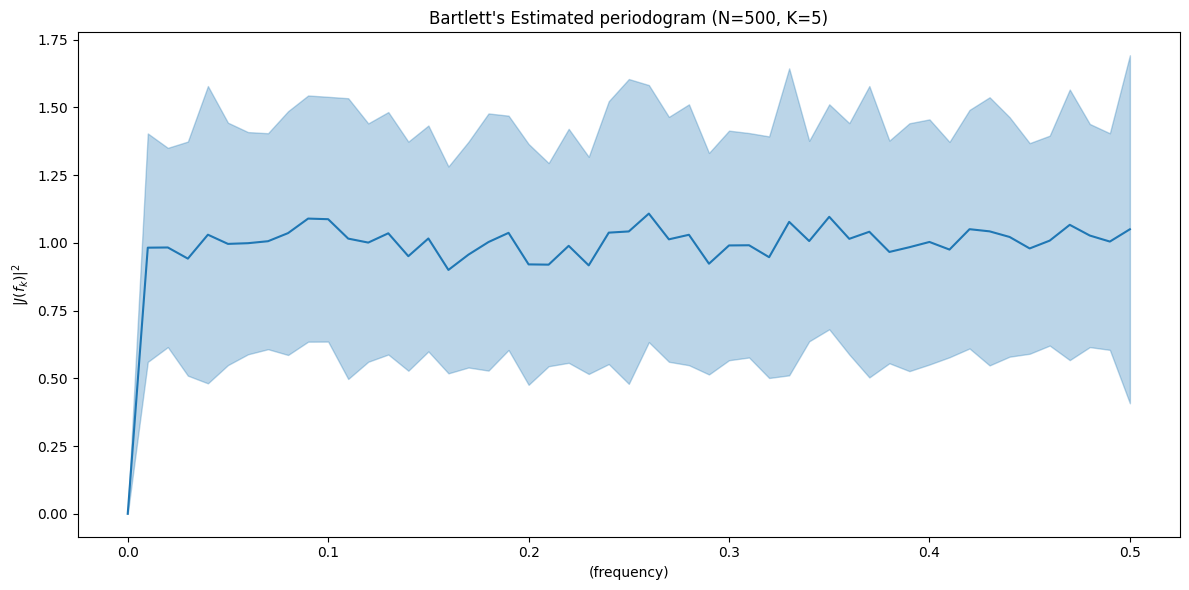

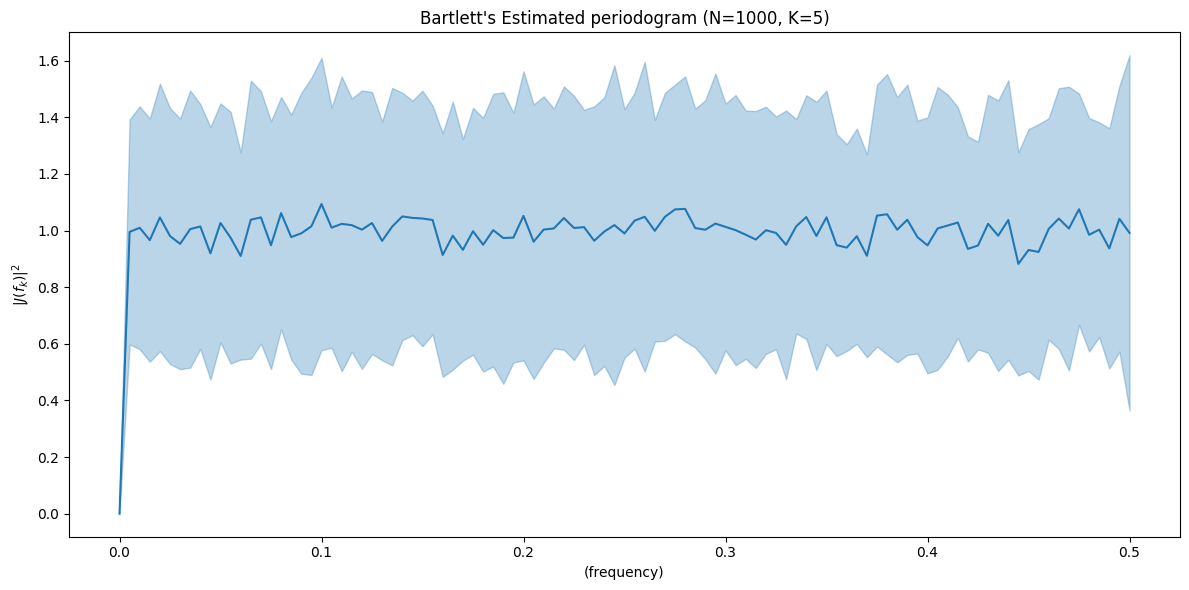

In [6]:
N_sim = 100
fs = 1 # Hz,
K = 5 # number of segments,
Ns = [200, 500, 1000]
for N in Ns:
    signals = np.random.randn(N_sim, N)

    L = N // K # length of each segment,
    freq_len = L // 2 + 1
    Jf_bartlett_all = np.zeros((N_sim, freq_len))

    for i,signal in enumerate(signals):
        Jf_bartlett_all[i] = bartlett_procedure(signal, K)

    mean_bartlett = Jf_bartlett_all.mean(axis=0)
    std_bartlett = Jf_bartlett_all.std(axis=0)
    # print(f\std_bartlett: {std_bartlett.mean(axis=0)}\),

    freqs = np.fft.rfftfreq(L, d=1/fs)

    plt.figure(figsize=(12, 6))
    plt.plot(freqs, mean_bartlett, color='C0', label=f"Average Bartlett's periodogram (K={K})")
    plt.fill_between(freqs, mean_bartlett - std_bartlett, mean_bartlett + std_bartlett, color='C0',alpha=0.3)
    plt.xlabel("(frequency)")
    plt.ylabel("$|J(f_k)|^2$")
    plt.title(f"Bartlett's Estimated periodogram (N={N}, K={K})")
    plt.tight_layout()
    if save:
        plt.savefig(f"figures/Bartlett_N{N}.png", dpi=300)
    plt.show()
    plt.close()


# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [7]:
from loadmydata.load_human_locomotion import download_from_remote_human_locomotion

In [8]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [9]:
#### Quick descriptive analysis of the dataset ###

y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"Len of training set: {len(X_train)}")
print(f"Number of Healthy patients: {len(y_train[y_train==0])}")
print(f"Number of Non-Healthy patients: {len(y_train[y_train==1])}")

print(f"Some dimensions of X_train {X_train[10].shape}, {X_train[40].shape}")

print(f"\nLen of test set: {len(X_test)}")

Len of training set: 168
Number of Healthy patients: 88
Number of Non-Healthy patients: 80
Some dimensions of X_train (82,), (72,)

Len of test set: 88


In [10]:
# Let's normalize features to be 0 mean and 1 variance

X_train_norm = [((x-x.mean()) / x.std()) for x in X_train]

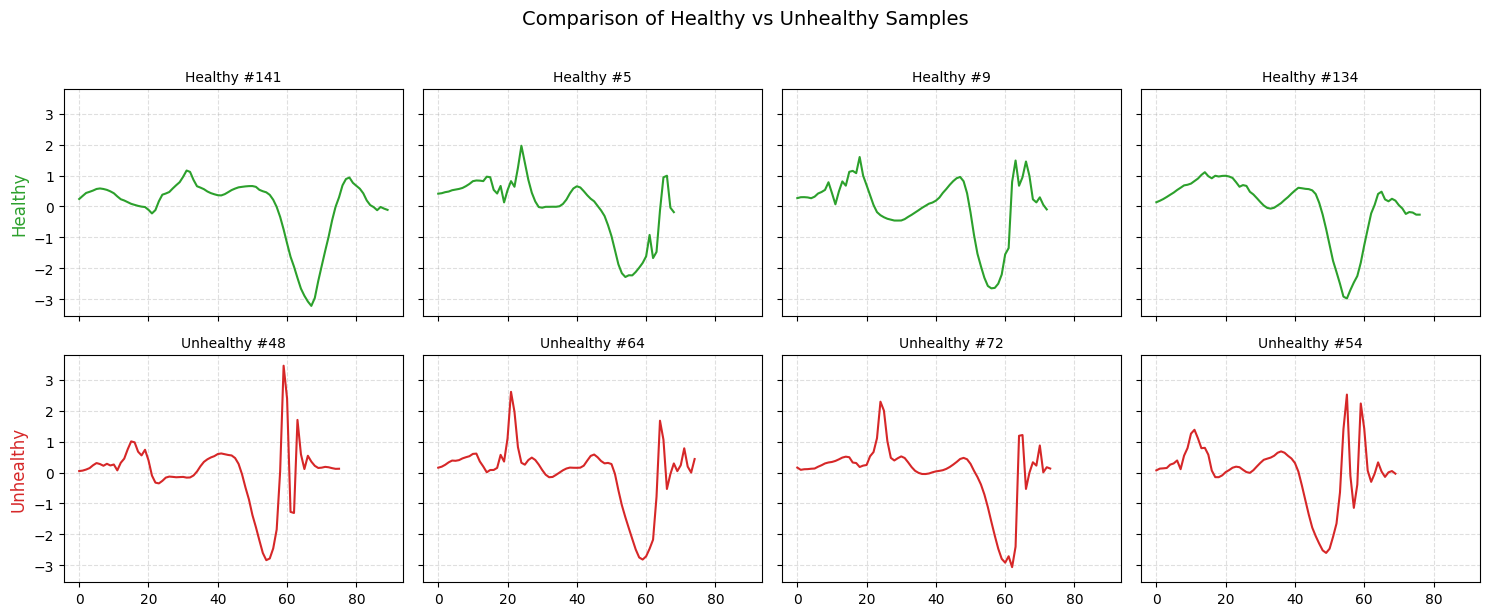

In [11]:
import numpy as np
import matplotlib.pyplot as plt

healthy_indices = np.where(y_train == 0)[0]
unhealthy_indices = np.where(y_train == 1)[0]

picked_zeros = np.random.choice(healthy_indices, 4, replace=False)
picked_ones = np.random.choice(unhealthy_indices, 4, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharex=True, sharey=True)

for i, (index_h, index_uh) in enumerate(zip(picked_zeros, picked_ones)):
    t_h = np.arange(len(X_train_norm[index_h]))
    t_uh = np.arange(len(X_train_norm[index_uh]))

    # Plot healthy signals
    axs[0, i].plot(t_h, X_train_norm[index_h], color="tab:green", lw=1.5)
    axs[0, i].set_title(f"Healthy #{index_h}", fontsize=10)
    axs[0, i].grid(True, linestyle="--", alpha=0.4)

    # Plot unhealthy signals
    axs[1, i].plot(t_uh, X_train_norm[index_uh], color="tab:red", lw=1.5)
    axs[1, i].set_title(f"Unhealthy #{index_uh}", fontsize=10)
    axs[1, i].grid(True, linestyle="--", alpha=0.4)



axs[0, 0].set_ylabel("Healthy", fontsize=12, color="tab:green")
axs[1, 0].set_ylabel("Unhealthy", fontsize=12, color="tab:red")

plt.suptitle("Comparison of Healthy vs Unhealthy Samples", fontsize=14, y=1.02)
plt.tight_layout()

In [12]:
from dtw import dtw
from numpy.linalg import norm

def get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray) -> float:
    """Compute DTW distance between two signals."""
    alignment = dtw(signal_1, signal_2, keep_internals=False, step_pattern="symmetric1", dist_method=lambda x, y: norm(x - y, ord=2), )
    return alignment.distance

def compute_dtw_matrix(X):
    n = len(X)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d = get_dtw_distance(X[i], X[j])
            D[i, j] = D[j, i] = d
    return D


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
D = compute_dtw_matrix(X_train)


<Axes: >

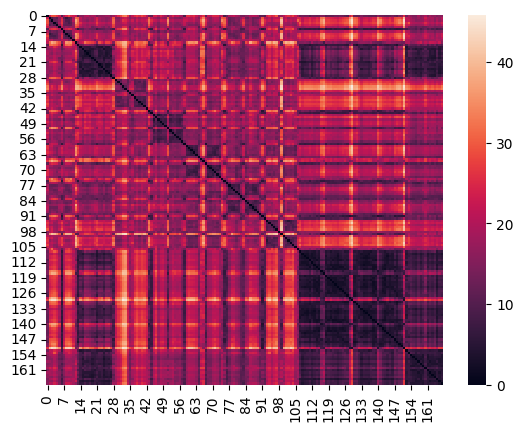

In [ ]:
import seaborn as sns 
sns.heatmap(D)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

def cross_validate_knn_precomputed(D, y, k_values, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True)
    results = {}
    
    for k in k_values:
        f1_scores = [] 
        for train_idx, val_idx in kf.split(D):
            D_train = D[np.ix_(train_idx, train_idx)]       # distances within training set
            D_val = D[np.ix_(val_idx, train_idx)]           # distances from val to train
            knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
            knn.fit(D_train, y[train_idx])
            y_pred = knn.predict(D_val)
            f1 = f1_score(y[val_idx], y_pred)
            f1_scores.append(f1)
        results[k] = np.mean(f1_scores)

    return results


In [ ]:
k_values = range(1,40)
results = cross_validate_knn_precomputed(D,y_train,k_values)

f1scores = [results[k] for k in k_values]

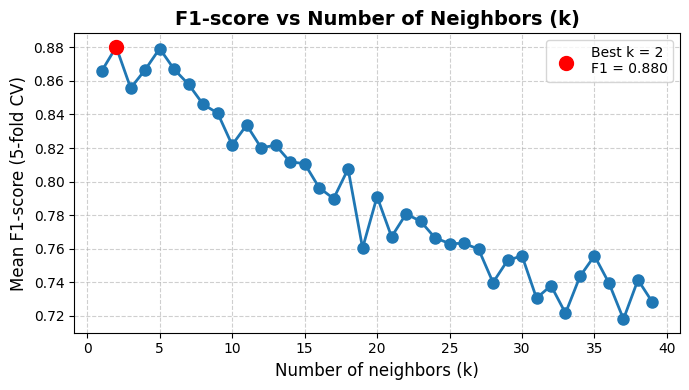

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(k_values, f1scores, marker='o', linestyle='-', linewidth=2, markersize=8)

# Style details
plt.title("F1-score vs Number of Neighbors (k)", fontsize=14, weight='bold')
plt.xlabel("Number of neighbors (k)", fontsize=12)
plt.ylabel("Mean F1-score (5-fold CV)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Highlight the best k
best_k = k_values[np.argmax(f1scores)]
best_f1 = np.max(f1scores)
plt.scatter(best_k, best_f1, color='red', s=100, zorder=5, label=f"Best k = {best_k}\nF1 = {best_f1:.3f}")

plt.legend()
plt.tight_layout()
plt.show()


## Question 11

In [ ]:
def compute_test_train_dtw(X_test, X_train):
    n_test, n_train = len(X_test), len(X_train)
    D_test_train = np.zeros((n_test, n_train))
    for i in range(n_test):
        for j in range(n_train):
            D_test_train[i, j] = get_dtw_distance(X_test[i], X_train[j])
    return D_test_train

D_test_train = compute_test_train_dtw(X_test, X_train)


In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric='precomputed')
knn_final.fit(D, y_train)

,n_neighbors,2
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'precomputed'
,metric_params,None
,n_jobs,None


In [ ]:
y_pred_test = knn_final.predict(D_test_train)

In [ ]:
# Indices
bad_healthy_idx = np.where(np.logical_and(y_pred_test == 1, y_test == 0))[0][0]
bad_unhealthy_idx = np.where(np.logical_and(y_pred_test == 0, y_test == 1))[0][0]


# Correct prediction
plt.figure(figsize=(10,4))
plt.plot(X_test[bad_healthy_idx], color='green')
plt.title(f"Correct\nTrue={y_test[bad_healthy_idx]} | Pred={y_pred_test[bad_healthy_idx]}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
if save:
    plt.savefig("figures/BCHS.png", dpi=300)
plt.show()
plt.close()  


# Incorrect prediction
plt.figure(figsize=(10,4))
plt.plot(X_test[bad_unhealthy_idx], color='red')
plt.title(f"Misclassified\nTrue={y_test[bad_unhealthy_idx]} | Pred={y_pred_test[bad_unhealthy_idx]}")
plt.xlabel("Time (samples)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
if save:
    plt.savefig("figures/BCNHS.png", dpi=300)
plt.show()
plt.close()  


In [ ]:
y_test[bad_healthy_idx]

np.int64(0)